# Voice activity detection

In [1]:
using Revise

In [2]:
using RxInfer, HDF5, PyPlot

┌ Info: Precompiling RxInfer [86711068-29c9-4ff7-b620-ae75d7495b3d]
└ @ Base loading.jl:1662


## Data 

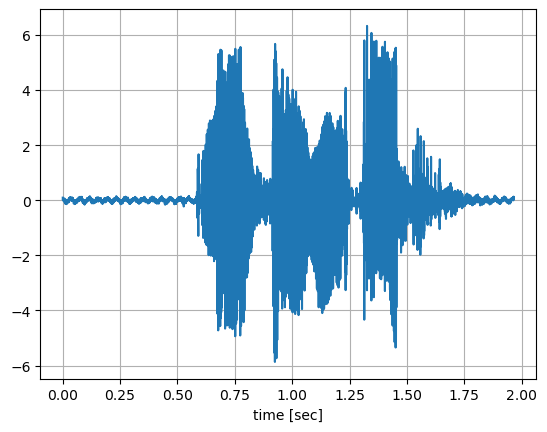

In [3]:
# fetch data
signal = h5read("../data/0000000001.h5", "signal")

# plot signal
plt.plot(collect(1:length(signal))./ 16000, signal)
plt.grid()
plt.xlabel("time [sec]");

In [4]:
ρ = mean(signal[9001:28001] ./ signal[9000:28000]);
σ2 = var(signal[9001:28001] - ρ .* signal[9000:28000]);

In [5]:
@model function model_VAD(ρ, σ2, prior)

    # specify observed signal
    y = datavar(Float64)

    # speech model
    s_prev ~ NormalMeanVariance(mean(prior), var(prior))
    s_new ~ NormalMeanVariance(ρ * s_prev, σ2)

    # noise model
    n_new ~ NormalMeanVariance(0.0, 0.01)

    # selection variable
    z ~ Categorical([0.5, 0.5])

    # specify mixture prior Distribution
    x ~ Switch(z, (s_new, n_new)) where { pipeline = RequireMarginal(switch) }

    # specify observation noise
    y ~ NormalMeanPrecision(x, 100.0)
    
    return y, z, s_new
end

In [6]:
@constraints function constraints_VAD()
    q(z) :: PointMass
end

constraints_VAD (generic function with 1 method)

In [7]:
# preallocate array
class = zeros(length(signal))

# specify prior
prior = Normal(0.0, 1.0)

# loop over data points
for n = 1:length(signal)

    # perform inference
    results_VAD = inference(
        model = model_VAD(ρ, σ2, prior),
        constraints = constraints_VAD(),
        data  = (y = signal[n], ),
        returnvars = (z = KeepLast(), s_new = KeepLast()),
        options = ( addons = (AddonLogScale(),), )
    )

    # extract information
    k = argmax(mean(results_VAD.posteriors[:z]))

    # update stuff if needed
    if k == 1
        # speech signal
        q_s = results_VAD.posteriors[:s_new]
        prior = Normal(mean(q_s), std(q_s))
        class[n] = 1
    else
        prior = Normal(0, 1.0)
    end
end

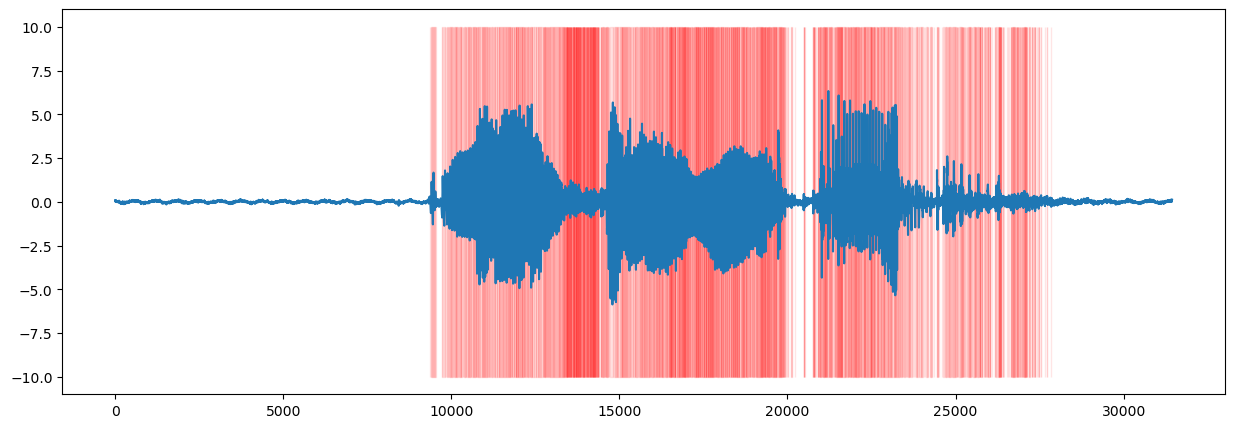

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000015FE730>

In [8]:
plt.figure(figsize=(15,5))
plt.fill_between(1:length(class), -10, 10, where=(class.==1), color="red", alpha = 0.1)
plt.plot(signal)

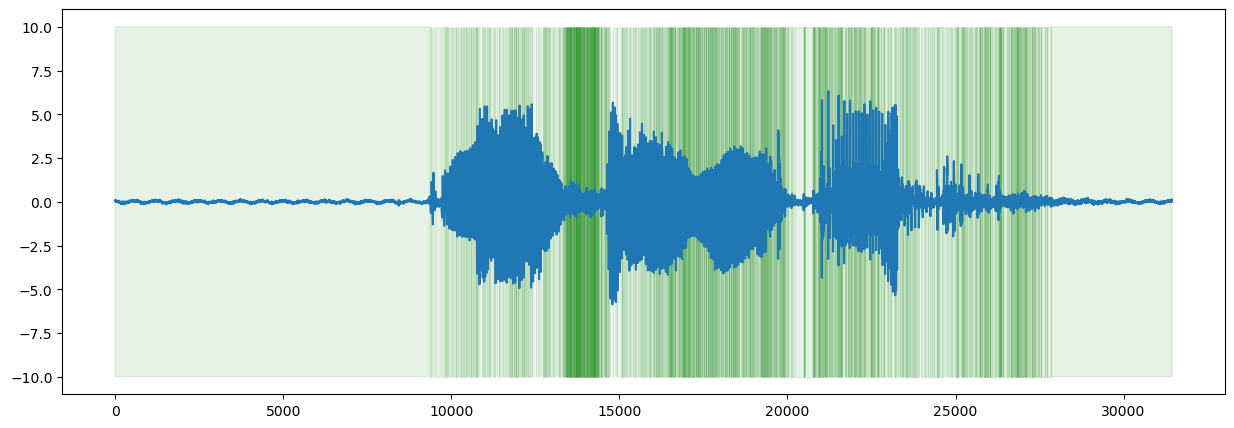

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000000006E0941C0>

┌ Error: Error watching manifest
│   exception = (Revise.ReviseEvalException("C:\\Users\\s151781\\.julia\\packages\\Compat\\ysINt\\src\\Compat.jl:147", ArgumentError("invalid type for argument s in method definition for size at C:\\Users\\s151781\\.julia\\packages\\Compat\\ysINt\\src\\Compat.jl:147"), Any[(top-level scope at Compat.jl:147, 1)]), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x000000002688b1fe])
└ @ Revise C:\Users\s151781\.julia\packages\Revise\do2nH\src\pkgs.jl:477
┌ Error: Error watching manifest
│   exception = (Revise.ReviseEvalException("C:\\Users\\s151781\\.julia\\packages\\Compat\\ysINt\\src\\Compat.jl:147", ArgumentError("invalid type for argument s in method definition for size at C:\\Users\\s151781\\.julia\\packages\\Compat\\ysINt\\src\\Compat.jl:147"), Any[(top-level scope at Compat.jl:147, 1)]), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x000000002688b1fe])
└ @ Revise C:\Users\s151781\.julia\packages\Revise\do2nH\src\pkgs.jl:477


In [9]:
plt.figure(figsize=(15,5))
plt.fill_between(1:length(class), -10, 10, where=(class.==0), color="green", alpha = 0.1)
plt.plot(signal)